# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

# import itertools
from pickle import dump
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

import classes.data as data_classes
import configuration as config

/mnt/arkk/llm_detector/classifier


In [2]:
# Instantiate the data class
data = data_classes.TrainTestData(
    training_data = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF,
    testing_data = config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF
)

# Set scoring metrics
scoring_metrics = ['neg_brier_score', 'neg_log_loss', 'accuracy']

## Off-the-shelf XGBoost classifier

In [3]:
# # Cross validate the model
# model = GradientBoostingClassifier()
# kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)

# results = cross_validate(
#     model, data.training.scale_features(), 
#     data.training.encode_labels(), 
#     scoring = scoring_metrics, 
#     cv = kfold, 
#     return_train_score = True
# )


In [4]:
# # Evaluate predictions
# for scoring_metric, dataset in itertools.product(scoring_metrics, ['train', 'test']):

#     metric_mean = round(results[f'{dataset}_{scoring_metric}'].mean(), 2)
#     metric_stdev = round(results[f'{dataset}_{scoring_metric}'].std(), 3)

#     print(f'CV {dataset} {scoring_metric}: {metric_mean:.2f} +/- {metric_stdev:.3f}')


Confusion matrix:
[[16195  1187]
 [ 1619  4346]]

Normalized confusion matrix:


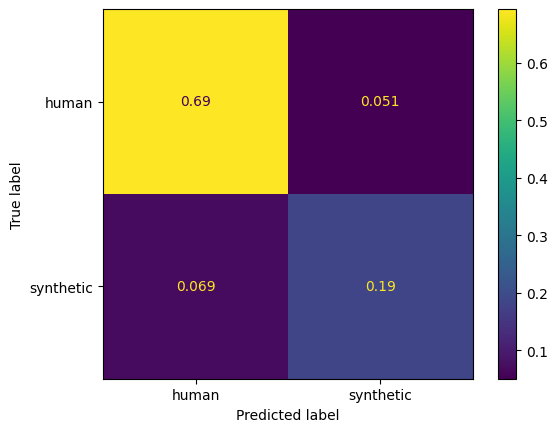

In [5]:
# Fit model on all of the training data
model = GradientBoostingClassifier()
model.fit(data.training.scale_features(), data.training.encode_labels())

# Make predictions for test data
predictions = model.predict(data.testing.scale_features())

# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    data.testing.scale_features(), 
    data.testing.encode_labels(), 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)


Confusion matrix:
[[16195  1187]
 [ 1619  4346]]

Normalized confusion matrix:
[[0.69366514 0.05084165]
 [0.0693451  0.18614811]]


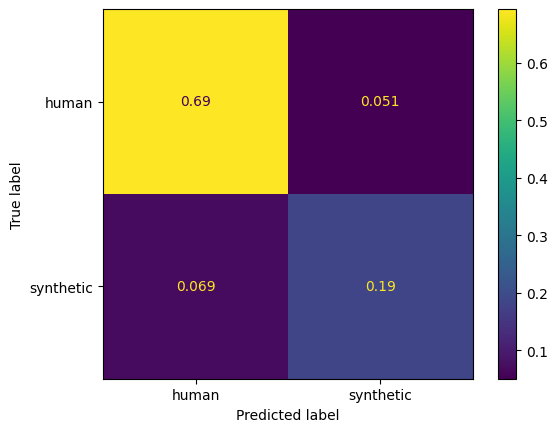

In [6]:
# Fit model on all of the training data
model = GradientBoostingClassifier()
model.fit(data.training.scale_features(), data.training.encode_labels())

# Make predictions for test data
predictions = model.predict(data.testing.scale_features())

# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
normalized_cm = cm / sum(sum(cm))
print(f'\nNormalized confusion matrix:')
print(normalized_cm)

_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    data.testing.scale_features(), 
    data.testing.encode_labels(), 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)

## Threshold tuned classifier

In [7]:
# Make probability predictions for test data
probability_predictions = model.predict_proba(data.testing.scale_features())
machine_probability_predictions = probability_predictions[:, 1]

In [8]:
binned_predictions = {}

for i in range(1, 101, 1):

    binned_predictions[i/100] = {'correct': 0, 'incorrect': 0}


bins = list(binned_predictions.keys())

for n, i in enumerate(bins):

    for true_label, predicted_label, machine_probability in zip(data.testing.encode_labels(), predictions, machine_probability_predictions):

        if machine_probability > i - 0.1 and machine_probability < i:
            if true_label == predicted_label:
                binned_predictions[i]['correct'] += 1

            elif true_label != predicted_label:
                binned_predictions[i]['incorrect'] += 1


fractions_correct = []

for bin, counts in binned_predictions.items():
    fraction_correct = counts['correct'] / (counts['correct'] + counts['incorrect'])
    fractions_correct.append(fraction_correct)

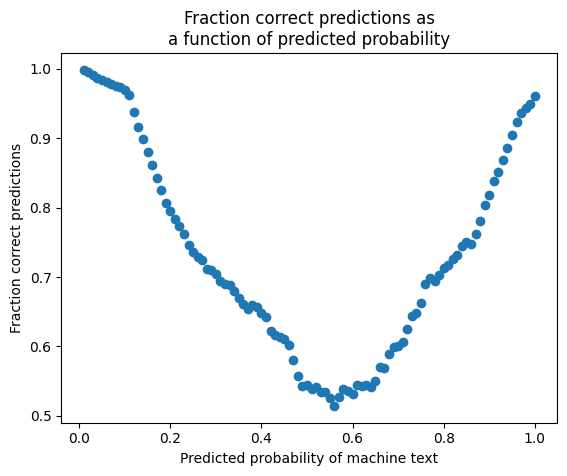

In [9]:
import matplotlib.pyplot as plt

plt.title('Fraction correct predictions as\na function of predicted probability')
plt.scatter(bins, fractions_correct)
plt.xlabel('Predicted probability of machine text')
plt.ylabel('Fraction correct predictions')
plt.show()

OK, cool - I like this plot. It makes an interesting point... Intuition might expect that at a predicted probabiilty of 0.5 the model is just guessing, so the actual fraction correct would be 50%. But, that's not what happens. The observed fraction correct makes it's closest approach to 0.5 at around a predicted probability of 0.55 or 0.56. I wonder if that has something to do with the class imbalance? Or maybe we should just put the decision threshold there?

In [10]:
tuned_predictions = []

for machine_probability_prediction in machine_probability_predictions:

    if machine_probability_prediction <= 0.5:
        tuned_predictions.append(0)

    else:
        tuned_predictions.append(1)


binned_predictions = {}

for i in range(1, 1001, 1):

    binned_predictions[i/1000] = {'correct': 0, 'incorrect': 0}


bins = list(binned_predictions.keys())

for n, i in enumerate(bins):

    for true_label, predicted_label, machine_probability in zip(data.testing.encode_labels(), tuned_predictions, machine_probability_predictions):

        if machine_probability > i - 0.1 and machine_probability < i:
            if true_label == predicted_label:
                binned_predictions[i]['correct'] += 1

            elif true_label != predicted_label:
                binned_predictions[i]['incorrect'] += 1


fractions_correct = []
populated_bins = []

for bin, counts in binned_predictions.items():

    if counts['correct'] + counts['incorrect'] != 0:

        fraction_correct = counts['correct'] / (counts['correct'] + counts['incorrect'])
        fractions_correct.append(fraction_correct)
        populated_bins.append(bin)

    # elif counts['correct'] + counts['incorrect'] == 0:
    #     fractions_correct.append(0)

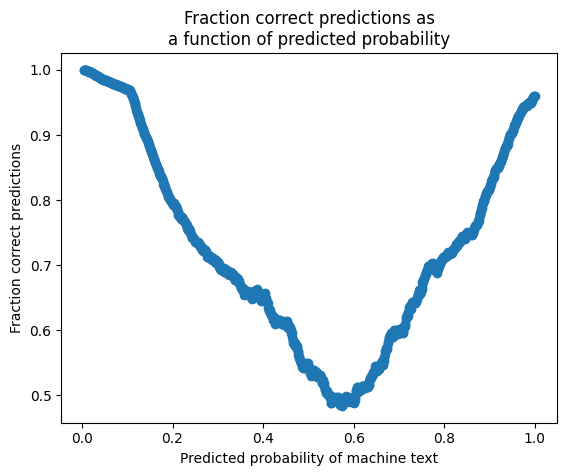

In [11]:
plt.title('Fraction correct predictions as\na function of predicted probability')
plt.scatter(populated_bins, fractions_correct)
plt.xlabel('Predicted probability of machine text')
plt.ylabel('Fraction correct predictions')
plt.show()


Confusion matrix:
[[16394   988]
 [ 1844  4121]]

Normalized confusion matrix:
[[0.70218872 0.04231807]
 [0.07898231 0.1765109 ]]


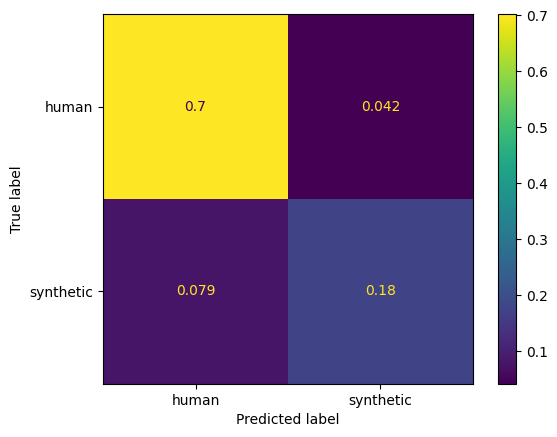

In [12]:
# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), tuned_predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
normalized_cm = cm / sum(sum(cm))
print(f'\nNormalized confusion matrix:')
print(normalized_cm)

disp = ConfusionMatrixDisplay(
    normalized_cm, 
    display_labels = ['human', 'synthetic']
)

_ = disp.plot()

Hmmm, ok - well it did something, but it's not better. we still have 88% correct. This is going to be tiny gains... Let's scan the decision threshold and pick the 'best' one...

In [18]:
winning_threshold = 0
winning_accuracy = 0

# Loop on decision thresholds
for threshold in list(range(500, 600, 1)):

    threshold = threshold / 1000

    # Make predictions using this threshold
    tuned_predictions = []

    for machine_probability_prediction in machine_probability_predictions:

        if machine_probability_prediction <= threshold:
            tuned_predictions.append(0)

        else:
            tuned_predictions.append(1)

    # Score the predictions for accuracy
    correct = 0
    incorrect = 0

    for tuned_prediction, true_label in zip(tuned_predictions, data.testing.encode_labels()):

        if tuned_prediction == true_label:
            correct += 1

        elif tuned_prediction != true_label:
            incorrect += 1

    # Update the winners
    accuracy = correct / (correct + incorrect)

    if accuracy > winning_accuracy:
        winning_accuracy = accuracy
        winning_threshold = threshold

print(f'Winning threshold: {winning_threshold}')

In [20]:
tuned_predictions = []

for machine_probability_prediction in machine_probability_predictions:

    if machine_probability_prediction <= winning_threshold:
        tuned_predictions.append(0)

    else:
        tuned_predictions.append(1)


binned_predictions = {}

for i in range(1, 1001, 1):

    binned_predictions[i/1000] = {'correct': 0, 'incorrect': 0}


bins = list(binned_predictions.keys())

for n, i in enumerate(bins):

    for true_label, predicted_label, machine_probability in zip(data.testing.encode_labels(), tuned_predictions, machine_probability_predictions):

        if machine_probability > i - 0.1 and machine_probability < i:
            if true_label == predicted_label:
                binned_predictions[i]['correct'] += 1

            elif true_label != predicted_label:
                binned_predictions[i]['incorrect'] += 1


fractions_correct = []
populated_bins = []

for bin, counts in binned_predictions.items():

    if counts['correct'] + counts['incorrect'] != 0:

        fraction_correct = counts['correct'] / (counts['correct'] + counts['incorrect'])
        fractions_correct.append(fraction_correct)
        populated_bins.append(bin)

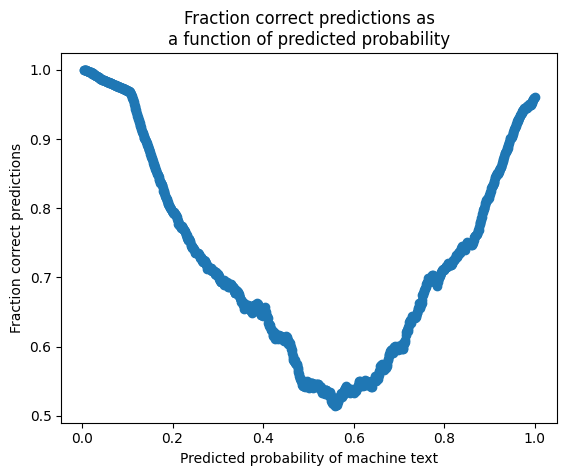

In [21]:
plt.title('Fraction correct predictions as\na function of predicted probability')
plt.scatter(populated_bins, fractions_correct)
plt.xlabel('Predicted probability of machine text')
plt.ylabel('Fraction correct predictions')
plt.show()


Confusion matrix:
[[16199  1183]
 [ 1622  4343]]

Normalized confusion matrix:
[[0.69383647 0.05067032]
 [0.06947359 0.18601962]]


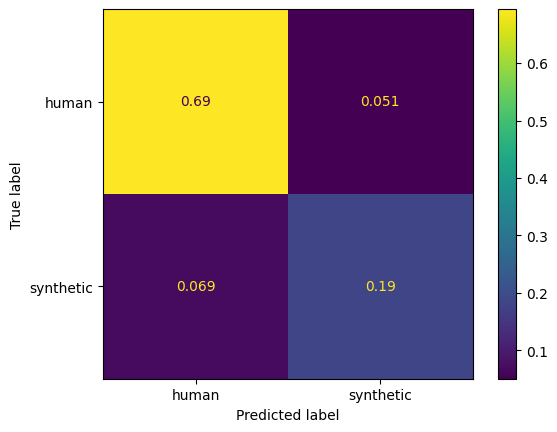

In [22]:
# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), tuned_predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
normalized_cm = cm / sum(sum(cm))
print(f'\nNormalized confusion matrix:')
print(normalized_cm)

disp = ConfusionMatrixDisplay(
    normalized_cm, 
    display_labels = ['human', 'synthetic']
)

_ = disp.plot()

Ok - so we are not changing the total fraction correct, just the false positives and negatives... Need to think about this a little bit more. Maybe try setting the threshold based on log-loss or Brier score. Also, we could tune to a low level of human text being called as synthetic or vice versa. Not sure how much it matters, because at the end of the day, we show the user the class probability anyway.

The V-plot is cool though, let's add that to the verbose response mode.

## Save the model

In [13]:
output_file = config.XGB_CLASSIFIER

with open(output_file, 'wb') as file:
    dump(model, file, protocol = 5)